In [2]:
# Import necessary libraries
import os
import importlib
import numpy as np
import platform
import sys
import psutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import image_loader
importlib.reload(image_loader)
from image_loader import ImageDatasetLoader
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import DataLoader
from image_loader import get_image_classification_loaders , your_transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from collections import Counter
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
from torchvision.models import ResNet50_Weights
from sklearn.metrics import accuracy_score
from torchvision.models import ResNet50_Weights
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import EfficientNet_B1_Weights
from sklearn.model_selection import train_test_split
from torchvision.models import ViT_B_16_Weights
from torchvision.models import ViT_B_32_Weights
import cv2

2025-08-15 14:06:04.491376: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-15 14:06:06.708736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755263167.363506   31221 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755263167.482368   31221 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755263169.621434   31221 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install tf-keras

In [29]:
print("Python Version:", sys.version)
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name(0))
print("OS:", platform.system(), platform.release())
!jupyter lab --version


Python Version: 3.9.21 (main, Feb 10 2025, 00:00:00) 
[GCC 11.5.0 20240719 (Red Hat 11.5.0-5)]
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
GPU: NVIDIA GeForce RTX 4070
OS: Linux 5.14.0-570.23.1.el9_6.x86_64
4.2.5


In [31]:
print("Processor:", platform.processor())
print("CPU cores (logical):", psutil.cpu_count(logical=True))
print("CPU cores (physical):", psutil.cpu_count(logical=False))
mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / (1024 ** 3):.2f} GB")
print(f"Available RAM: {mem.available / (1024 ** 3):.2f} GB")


Processor: x86_64
CPU cores (logical): 20
CPU cores (physical): 12
Total RAM: 30.84 GB
Available RAM: 24.77 GB


In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define transforms (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# Initialize dataset and dataloaders
csv_file = r"/uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/uc-multimodal-main/dataframe_complete.csv"  # Path to the CSV file
img_dir = r"/uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/image_folder"  # Path to the image directory

dataset = ImageDatasetLoader(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check dataset size
print(f"Number of samples in dataset: {len(dataset)}")

# Test loading a batch of data
for images, labels in train_loader:
    print(images.shape)  # Should print torch.Size([32, 3, 224, 224]) for batch size 32 and 224x224 images
    print(labels)  # MES numeric labels for the batch
    break  # Exit after the first batch

image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

# Count the number of images
num_images = len(image_files)
print(f"Number of images in the folder: {num_images}")


Label2idx mapping in ImageDatasetLoader: {np.int64(1): 0, np.int64(0): 1, np.int64(2): 2, np.int64(3): 3}
Number of samples in dataset: 981
torch.Size([32, 3, 224, 224])
tensor([2, 2, 2, 1, 2, 2, 2, 3, 0, 1, 1, 3, 0, 0, 1, 1, 1, 3, 2, 3, 2, 2, 2, 3,
        3, 2, 2, 2, 0, 1, 2, 2])
Number of images in the folder: 906


In [5]:
# Data Augmentation + Preprocessing Pipeline for Training Data
your_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.02),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


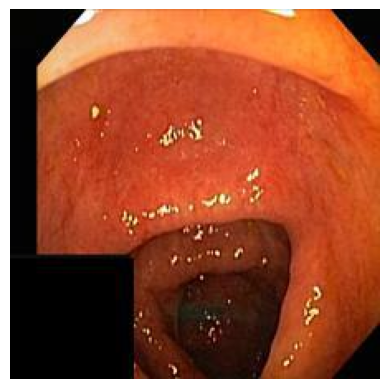

Label: tensor(1)


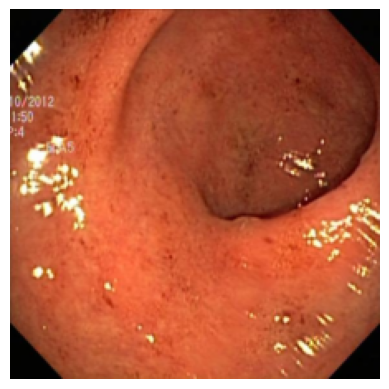

Label: tensor(2)


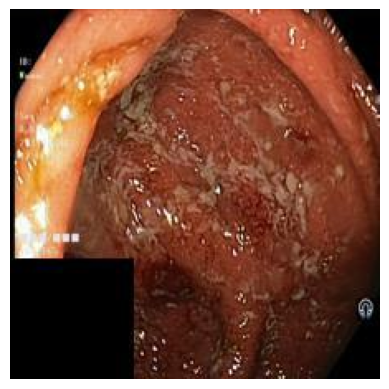

Label: tensor(2)


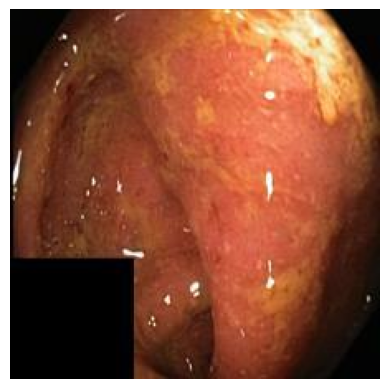

Label: tensor(2)


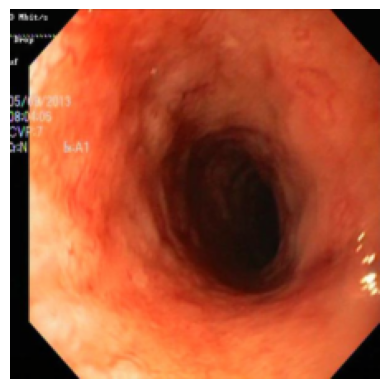

Label: tensor(2)


In [6]:
# Function to show image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor CHW to HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show multiple images
for i in range(5):
    imshow(images[i])
    print("Label:", labels[i])

In [7]:
# ---- LOAD & SPLIT CSV ----

csv_file = r"/uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/uc-multimodal-main/dataframe_complete.csv"  # Path to the CSV file
img_dir = r"//uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/image_folder"

df = pd.read_csv(csv_file)

# Ensure consistent column names
df = df.rename(columns={"image_path": "img_url", "description": "caption"})

# Perform a single split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42 , shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42 , shuffle=True)

# Print sizes to confirm
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")


Train: 784, Validation: 98, Test: 99


In [8]:
# ---- Full classification dataset ----
full_dataset = ImageDatasetLoader(csv_file=csv_file, img_dir=img_dir, transform=your_transforms)

# Use the SAME indices from train_df, val_df, test_df
train_idx = train_df.index.tolist()
val_idx = val_df.index.tolist()
test_idx = test_df.index.tolist()

from torch.utils.data import Subset

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")


Label2idx mapping in ImageDatasetLoader: {np.int64(1): 0, np.int64(0): 1, np.int64(2): 2, np.int64(3): 3}
Train size: 784 | Val size: 98 | Test size: 99


In [12]:
df = pd.read_csv(csv_file)

# Clean MES and UCEIS columns
df['mes_class'] = df['mes_scoring_0_3'].astype(str).str.extract(r'(\d+)').astype(int)
df['uceis_score'] = df['uceis_score'].astype(str).str.extract(r'(\d+)').astype(float)

# Create summary
summary = {
    "Total Samples": len(df),
    "Unique Captions": df['description'].nunique(),
    "Avg. Caption Length (tokens)": df['description'].apply(lambda x: len(str(x).split())).mean(),
    "MES Class Distribution": df['mes_class'].value_counts().sort_index().to_dict(),
    "Avg. UCEIS Score": df['uceis_score'].mean()
}

summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])
print(summary_df)


                                                         Value
Total Samples                                              981
Unique Captions                                             99
Avg. Caption Length (tokens)                         26.438328
MES Class Distribution        {0: 117, 1: 226, 2: 511, 3: 127}
Avg. UCEIS Score                                      3.094801


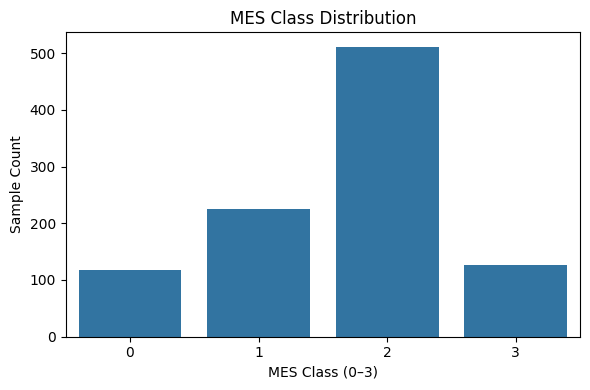

In [23]:
# Count MES classes (now using cleaned numeric column)
mes_counts = df['mes_class'].value_counts().sort_index()

# Bar Chart
plt.figure(figsize=(6, 4))
sns.barplot(x=mes_counts.index.astype(str), y=mes_counts.values)
plt.title("MES Class Distribution")
plt.xlabel("MES Class (0–3)")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

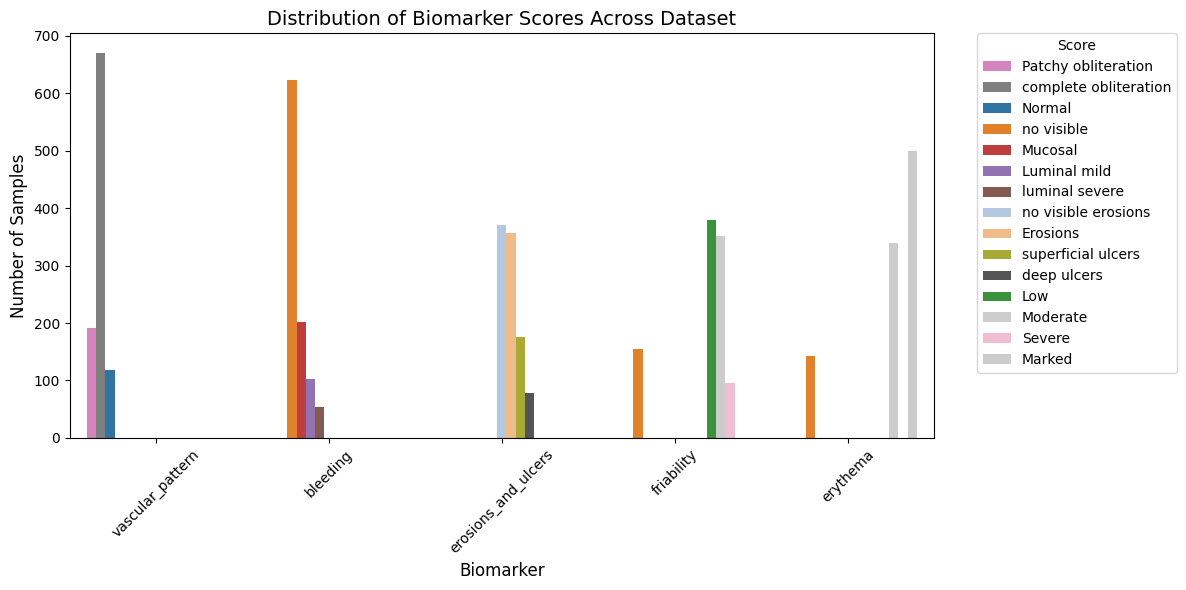

In [22]:
# Define biomarkers
biomarkers = [
    'vascular_pattern',
    'bleeding',
    'erosions_and_ulcers',
    'friability',
    'erythema'
]
# Melt the DataFrame
melted = df.melt(
    id_vars=['mes_class'],
    value_vars=biomarkers,
    var_name='Biomarker',
    value_name='Score'
)

melted['Score'] = melted['Score'].astype(str)

# Unique categories in Score
unique_scores = sorted(melted['Score'].unique())

# Manually define a color for each unique category
custom_palette = {
   'Normal': '#1f77b4',              # blue
    'no visible': '#ff7f0e',          # bright orange
    'Low': '#2ca02c',                 # green
    'Mucosal': '#d62728',             # red
    'Luminal mild': '#9467bd',        # purple
    'luminal severe': '#8c564b',      # brown
    'Patchy obliteration': '#e377c2', # pink
    'complete obliteration': '#7f7f7f', # grey
    'deep ulcers': '#17becf',         # cyan
    'superficial ulcers': '#bcbd22',  # olive green
    'Erosions': '#ffbb78',            # light orange
    'no visible erosions': '#aec7e8', # light blue
    'Severe': '#f7b6d2',        
}

# Fix conflict: 'deep ulcers' and 'no visible' were both grey, assign distinct color
custom_palette['deep ulcers'] = '#545454'  # darker grey

# Assign a default color for any other categories not listed manually
default_color = '#cccccc'  # light grey

for score in unique_scores:
    if score not in custom_palette:
        custom_palette[score] = default_color

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=melted, x='Biomarker', hue='Score', palette=custom_palette)

plt.title("Distribution of Biomarker Scores Across Dataset", fontsize=14)
plt.xlabel("Biomarker", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)

plt.legend(title="Score", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


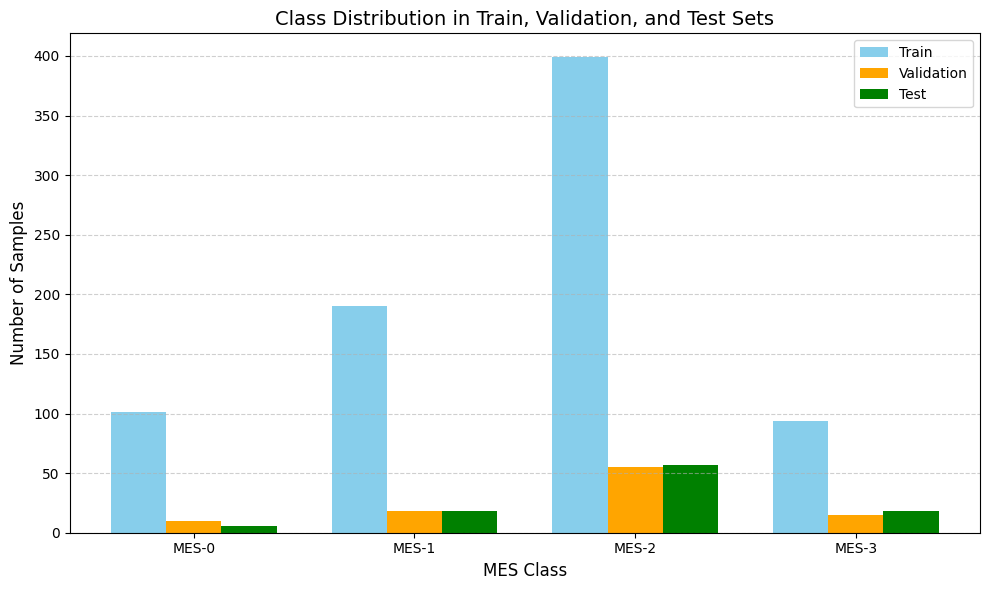

In [33]:
# ---- Count class distributions ----
train_counts = Counter(train_df['mes_scoring_0_3'])
val_counts = Counter(val_df['mes_scoring_0_3'])
test_counts = Counter(test_df['mes_scoring_0_3'])

# ---- Ensure consistent class order ----
classes = sorted(df['mes_scoring_0_3'].unique())

train_vals = [train_counts.get(cls, 0) for cls in classes]
val_vals = [val_counts.get(cls, 0) for cls in classes]
test_vals = [test_counts.get(cls, 0) for cls in classes]

# ---- Plotting ----
x = range(len(classes))
bar_width = 0.25

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width for i in x], train_vals, width=bar_width, label='Train', color='skyblue')
plt.bar(x, val_vals, width=bar_width, label='Validation', color='orange')
plt.bar([i + bar_width for i in x], test_vals, width=bar_width, label='Test', color='green')

plt.xlabel('MES Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in Train, Validation, and Test Sets', fontsize=14)
plt.xticks(ticks=x, labels=[str(c) for c in classes])
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

IMAGE CLASSIFICATION - PART 1

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /uolstore/home/users/qgqq3572/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|███████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 102MB/s]


Epoch [1/20], Train Loss: 1.1593, Train Acc: 0.5394, Val Loss: 1.0749, Val Acc: 0.6531
✅ Saved best model with Validation Loss: 1.0749
Epoch [2/20], Train Loss: 0.9348, Train Acc: 0.6793, Val Loss: 0.9061, Val Acc: 0.7143
✅ Saved best model with Validation Loss: 0.9061
Epoch [3/20], Train Loss: 0.8791, Train Acc: 0.7026, Val Loss: 0.8225, Val Acc: 0.7551
✅ Saved best model with Validation Loss: 0.8225
Epoch [4/20], Train Loss: 0.8356, Train Acc: 0.7230, Val Loss: 1.1282, Val Acc: 0.6190
⚠️ No improvement in validation loss for 1 epoch(s).
Epoch [5/20], Train Loss: 0.7987, Train Acc: 0.7609, Val Loss: 0.8342, Val Acc: 0.7347
⚠️ No improvement in validation loss for 2 epoch(s).
Epoch [6/20], Train Loss: 0.7565, Train Acc: 0.7799, Val Loss: 0.8817, Val Acc: 0.7415
⚠️ No improvement in validation loss for 3 epoch(s).
Epoch [7/20], Train Loss: 0.7266, Train Acc: 0.7945, Val Loss: 0.7973, Val Acc: 0.7755
✅ Saved best model with Validation Loss: 0.7973
Epoch [8/20], Train Loss: 0.6833, Train 

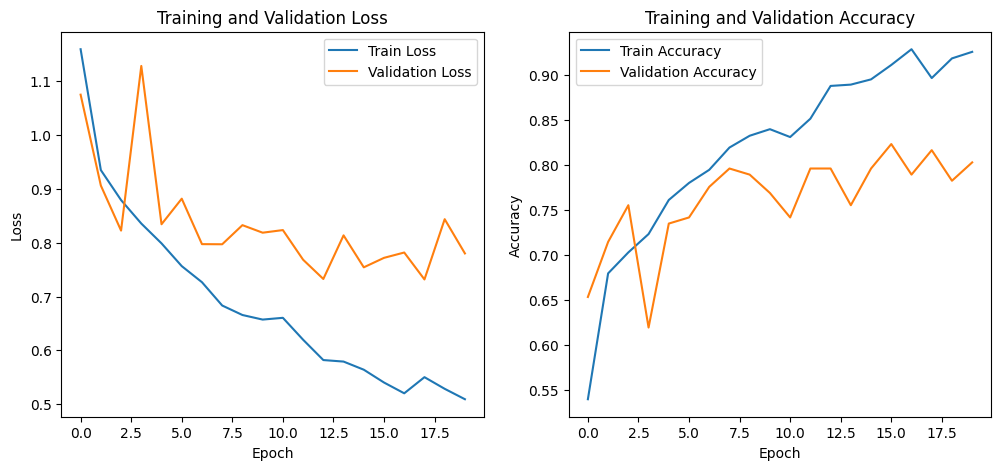

In [20]:
# RESNET50 MODEL

from image_loader import ImageDatasetLoader, your_transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths

# Hyperparameters
batch_size = 32
epochs = 20
learning_rate = 0.0005
weight_decay = 0.0001
dropout_prob = 0.5
early_stop_patience = 5  # Stop if no improvement after 5 epochs

# Load model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
num_classes = len(full_dataset.label2idx)

# Replace final layer
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Training loop
for epoch in range(epochs):
    if early_stop:
        print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
        break

    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_accuracy += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = running_accuracy / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():
        for images_val, labels_val in val_loader:
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            outputs_val = model(images_val)
            val_loss = criterion(outputs_val, labels_val)

            val_running_loss += val_loss.item() * images_val.size(0)
            _, predicted_val = torch.max(outputs_val, 1)
            val_running_accuracy += (predicted_val == labels_val).sum().item()

    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_accuracy = val_running_accuracy / len(val_dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # Early Stopping Logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model_resnet50_notebook2.pth')
        print(f"✅ Saved best model with Validation Loss: {best_val_loss:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement in validation loss for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= early_stop_patience:
            early_stop = True

print("🏁 Finished Training.")

# Plot losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.savefig('loss_accuracy_plot_resnet50_notebook.png')
plt.show()


In [40]:
# RESNET50 TEST CODE

batch_size = 32
dropout_prob = 0.5  # Ensure this matches the training dropout probability

# Define the same transforms used for validation/testing
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Use the same resize as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

model.load_state_dict(
    torch.load('best_model_resnet50_notebook2.pth'))  # Load your saved best model
model.to(device)
model.eval()  # Set the model to evaluation mode

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy().flatten())

# Calculate accuracy on the test data
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the Test Data: {test_accuracy:.4f}")


Accuracy on the Test Data: 0.7576



📊 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      1.00      0.92         6
     Class 1       0.62      0.44      0.52        18
     Class 2       0.77      0.88      0.82        57
     Class 3       0.86      0.67      0.75        18

    accuracy                           0.77        99
   macro avg       0.77      0.75      0.75        99
weighted avg       0.76      0.77      0.76        99



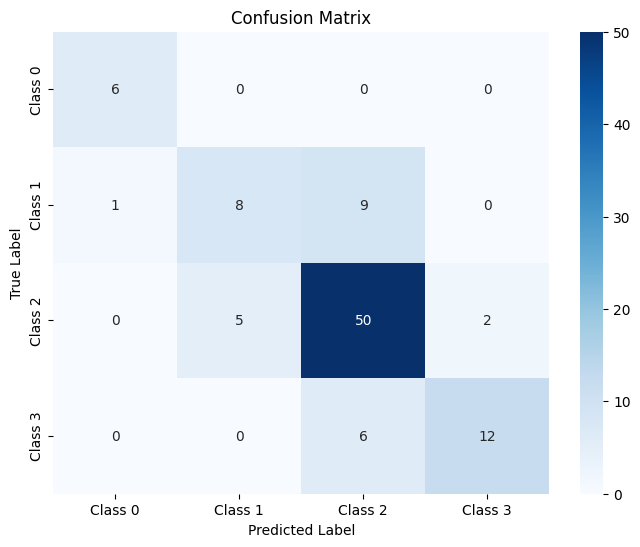

In [41]:
# RESNET 50 CLASSIFICATION REPORT AND CONFUSION MATRIX

model.eval()  # Set model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification Report ---
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1", "Class 2", "Class 3"]))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Using device: cuda
Label2idx mapping in ImageDatasetLoader: {np.int64(1): 0, np.int64(0): 1, np.int64(2): 2, np.int64(3): 3}
Train size: 686 | Val size: 147 | Test size: 148
Epoch [1/20], Train Loss: 1.2335, Train Acc: 0.4971, Val Loss: 1.1437, Val Acc: 0.5918
✅ Saved best model with Validation Loss: 1.1437
Epoch [2/20], Train Loss: 1.0569, Train Acc: 0.5991, Val Loss: 0.9910, Val Acc: 0.6122
✅ Saved best model with Validation Loss: 0.9910
Epoch [3/20], Train Loss: 1.0070, Train Acc: 0.6312, Val Loss: 0.9506, Val Acc: 0.6463
✅ Saved best model with Validation Loss: 0.9506
Epoch [4/20], Train Loss: 0.9760, Train Acc: 0.6603, Val Loss: 0.9163, Val Acc: 0.7279
✅ Saved best model with Validation Loss: 0.9163
Epoch [5/20], Train Loss: 0.9099, Train Acc: 0.6735, Val Loss: 0.9742, Val Acc: 0.6259
⚠️ No improvement in validation loss for 1 epoch(s).
Epoch [6/20], Train Loss: 0.8478, Train Acc: 0.7332, Val Loss: 0.8447, Val Acc: 0.7279
✅ Saved best model with Validation Loss: 0.8447
Epoch [7/20

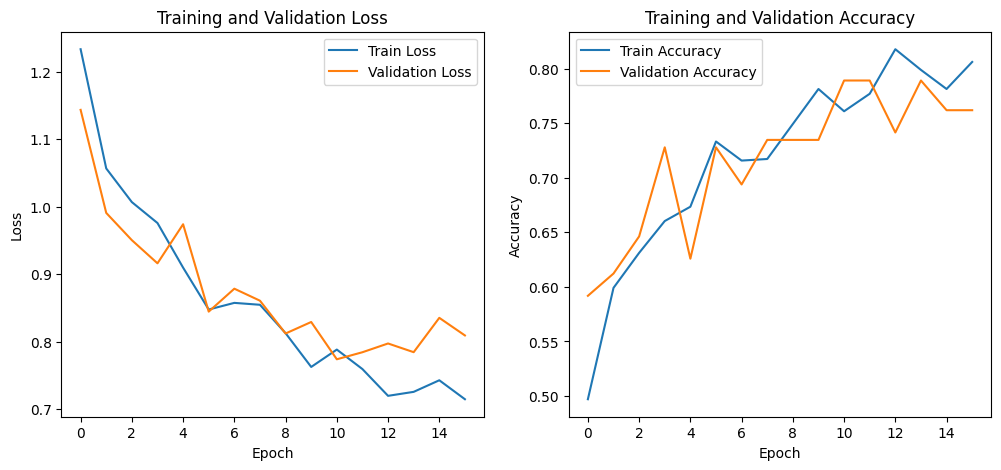

In [5]:
# EFFICIENTNETB1 MODEL
from image_loader import ImageDatasetLoader, your_transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Hyperparameters
batch_size = 32
epochs = 20
learning_rate = 0.0005
weight_decay = 0.0001
dropout_prob = 0.5
early_stop_patience = 5

# Load Data
full_dataset = ImageDatasetLoader(csv_file=csv_file, img_dir=img_dir, transform=your_transforms)
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
labels = full_dataset.dataframe['mes_numeric'].values


# Load EfficientNet B1
model = models.efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
num_ftrs = model.classifier[1].in_features
num_classes = len(full_dataset.label2idx)
07een
# Replace classifier
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Training loop
for epoch in range(epochs):
    if early_stop:
        print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
        break

    model.train()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_accuracy += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = running_accuracy / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation
    model.eval()
    val_running_loss, val_running_accuracy = 0.0, 0.0
    with torch.no_grad():
        for images_val, labels_val in val_loader:
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            outputs_val = model(images_val)
            val_loss = criterion(outputs_val, labels_val)

            val_running_loss += val_loss.item() * images_val.size(0)
            _, predicted_val = torch.max(outputs_val, 1)
            val_running_accuracy += (predicted_val == labels_val).sum().item()

    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_accuracy = val_running_accuracy / len(val_dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # Early Stopping Logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model_efficientb1.pth')
        print(f"✅ Saved best model with Validation Loss: {best_val_loss:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement in validation loss for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= early_stop_patience:
            early_stop = True

print("🏁 Finished Training.")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.savefig('loss_accuracy_plot_efficientb1.png')
plt.show()



📊 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.87      0.84        15
     Class 1       0.74      0.50      0.60        34
     Class 2       0.71      0.88      0.79        80
     Class 3       0.45      0.26      0.33        19

    accuracy                           0.71       148
   macro avg       0.68      0.63      0.64       148
weighted avg       0.70      0.71      0.69       148



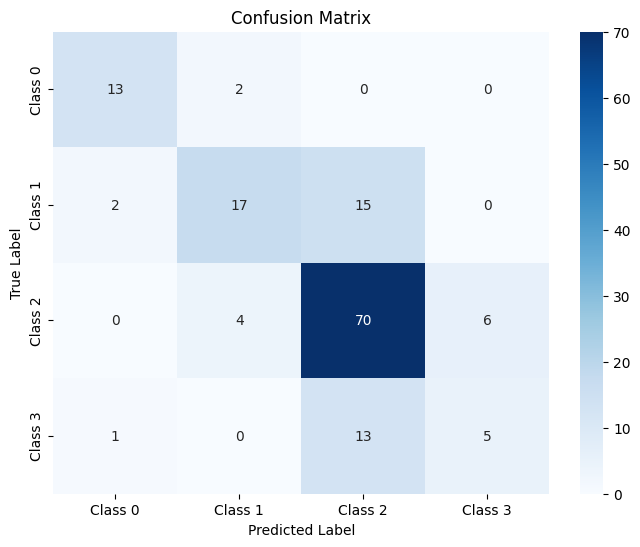

In [7]:
# EFFICIENTNETB1 MODEL CLASSIFICATION REPORT AND CONFUSION MATRIX

model.eval()  # Set model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification Report ---
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1", "Class 2", "Class 3"]))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Using device: cuda
Label2idx mapping in ImageDatasetLoader: {np.int64(1): 0, np.int64(0): 1, np.int64(2): 2, np.int64(3): 3}
Train: 588, Val: 196, Test: 197
Epoch [1/20] | Train Loss: 1.3056, Acc: 0.4235 | Val Loss: 1.2241, Acc: 0.4286
✅ Saved best model at epoch 1
Epoch [2/20] | Train Loss: 1.0918, Acc: 0.5663 | Val Loss: 0.9796, Acc: 0.6633
✅ Saved best model at epoch 2
Epoch [3/20] | Train Loss: 1.0532, Acc: 0.6105 | Val Loss: 1.0431, Acc: 0.6173
Epoch [4/20] | Train Loss: 0.9292, Acc: 0.6990 | Val Loss: 0.8799, Acc: 0.7194
✅ Saved best model at epoch 4
Epoch [5/20] | Train Loss: 0.9231, Acc: 0.7007 | Val Loss: 0.8509, Acc: 0.7245
✅ Saved best model at epoch 5
Epoch [6/20] | Train Loss: 0.8719, Acc: 0.6973 | Val Loss: 0.8605, Acc: 0.7398
Epoch [7/20] | Train Loss: 0.8309, Acc: 0.7500 | Val Loss: 0.9018, Acc: 0.7092
Epoch [8/20] | Train Loss: 0.7586, Acc: 0.7908 | Val Loss: 0.9222, Acc: 0.6939
Epoch [9/20] | Train Loss: 0.8009, Acc: 0.7568 | Val Loss: 0.9321, Acc: 0.6990
Epoch [10/20

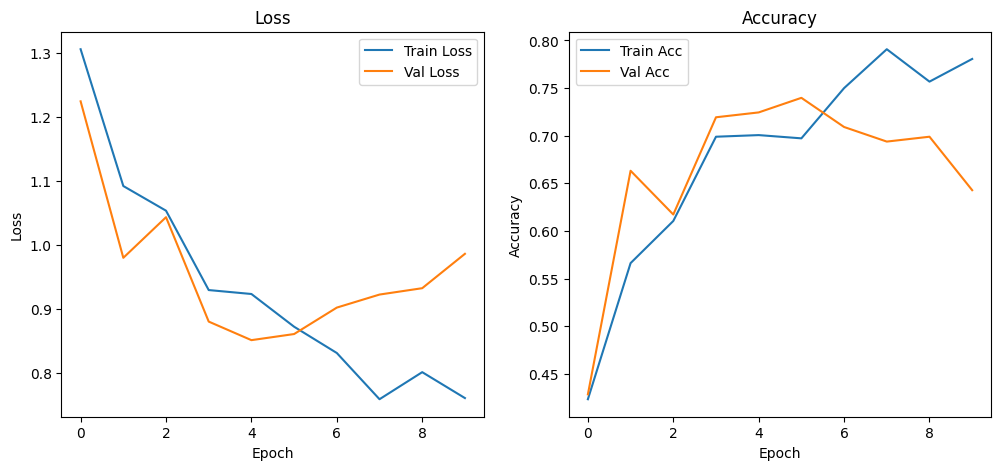

In [19]:
# ViT_B_16 MODEL 
from image_loader import ImageDatasetLoader, your_transforms


# Hyperparameters
batch_size = 32
epochs = 20
learning_rate = 5e-5
weight_decay = 1e-4
dropout_prob = 0.5
early_stop_patience = 5

# Transforms for ViT (224x224 input size)
vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT uses 224x224 by default
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = ImageDatasetLoader(csv_file=csv_file, img_dir=img_dir, transform=your_transforms)
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
labels = full_dataset.dataframe['mes_numeric'].values


# Load ViT model
model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
num_ftrs = model.heads.head.in_features
num_classes = len(full_dataset.label2idx)

# Replace classifier head
model.heads.head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Tracking variables
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Training loop
for epoch in range(epochs):
    if early_stop:
        print(f"🛑 Early stopping triggered at epoch {epoch + 1}")
        break

    model.train()
    running_loss, running_acc = 0.0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_acc += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_acc / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_images.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_acc += (val_preds == val_labels).sum().item()

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_acc / len(val_dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    scheduler.step()

    print(f"Epoch [{epoch + 1}/{epochs}] | Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    # Save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model_vit_b16.pth')
        print(f"✅ Saved best model at epoch {epoch + 1}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            early_stop = True
            print("⛔ Early stopping...")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()


In [20]:
# ViT_B_16 MODEL
# Hyperparameters

batch_size = 32

# Transforms for ViT (224x224 input size)
vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT uses 224x224 by default
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = ImageDatasetLoader(csv_file=csv_file, img_dir=img_dir, transform=your_transforms)
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
labels = full_dataset.dataframe['mes_numeric'].values

# Load the best ViT model
model.load_state_dict(torch.load('best_model_vit_b16.pth'))
model = model.to(device)

# Set model to evaluation mode
model.eval()

# Track predictions and ground truth
predictions = []
ground_truth = []

# Testing loop
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())


# Accuracy
accuracy = (torch.tensor(predictions) == torch.tensor(ground_truth)).float().mean()
print(f"Test Accuracy: {accuracy:.4f}")


Using device: cuda
Label2idx mapping in ImageDatasetLoader: {np.int64(1): 0, np.int64(0): 1, np.int64(2): 2, np.int64(3): 3}
Train: 588, Val: 196, Test: 197
Test Accuracy: 0.7513


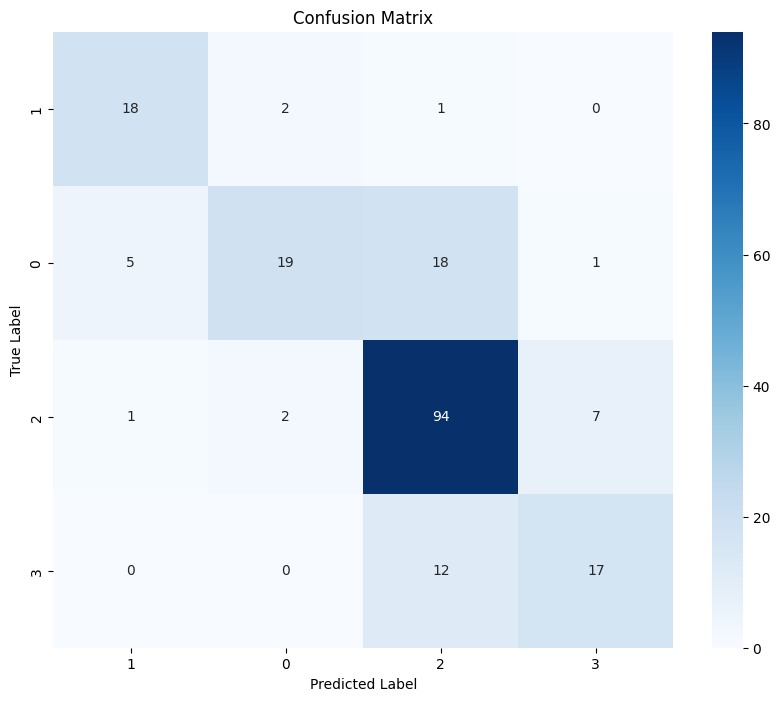


Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.86      0.80        21
           0       0.83      0.44      0.58        43
           2       0.75      0.90      0.82       104
           3       0.68      0.59      0.63        29

    accuracy                           0.75       197
   macro avg       0.75      0.70      0.71       197
weighted avg       0.76      0.75      0.74       197


Test Accuracy: 0.7513


In [21]:
# ViT_B_16 MODEL CLASSIFICATION REPORT AND CONFUSION MATRIX

# Convert predictions and ground_truth to NumPy arrays if they are PyTorch tensors
if isinstance(predictions, list):
    predictions = np.array(predictions)
if isinstance(ground_truth, list):
    ground_truth = np.array(ground_truth)

# Get class names as strings
class_names = [str(key) for key in full_dataset.label2idx.keys()]

# Generate confusion matrix
cm = confusion_matrix(ground_truth, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report (includes precision, recall, F1-score, and accuracy)
print("\nClassification Report:")
print(classification_report(ground_truth, predictions, target_names=class_names))

# If you specifically want to print the accuracy separately (though it's in the report):
accuracy = np.mean(predictions == ground_truth)
print(f"\nTest Accuracy: {accuracy:.4f}")

Using device: cuda
Label2idx mapping in ImageDatasetLoader: {np.int64(1): 0, np.int64(0): 1, np.int64(2): 2, np.int64(3): 3}
Train: 588, Val: 196, Test: 197
Epoch [1/20] | Train Loss: 1.4351, Acc: 0.3180 | Val Loss: 1.3050, Acc: 0.2755
✅ Saved best model at epoch 1
Epoch [2/20] | Train Loss: 1.2651, Acc: 0.4201 | Val Loss: 1.5644, Acc: 0.2857
Epoch [3/20] | Train Loss: 1.2486, Acc: 0.4915 | Val Loss: 1.1026, Acc: 0.5969
✅ Saved best model at epoch 3
Epoch [4/20] | Train Loss: 1.1304, Acc: 0.5561 | Val Loss: 1.1009, Acc: 0.5816
✅ Saved best model at epoch 4
Epoch [5/20] | Train Loss: 1.1202, Acc: 0.5391 | Val Loss: 1.0695, Acc: 0.6224
✅ Saved best model at epoch 5
Epoch [6/20] | Train Loss: 1.0810, Acc: 0.5612 | Val Loss: 1.0214, Acc: 0.6582
✅ Saved best model at epoch 6
Epoch [7/20] | Train Loss: 1.0667, Acc: 0.5629 | Val Loss: 1.0250, Acc: 0.6071
Epoch [8/20] | Train Loss: 1.0434, Acc: 0.5850 | Val Loss: 0.9970, Acc: 0.5816
✅ Saved best model at epoch 8
Epoch [9/20] | Train Loss: 0.98

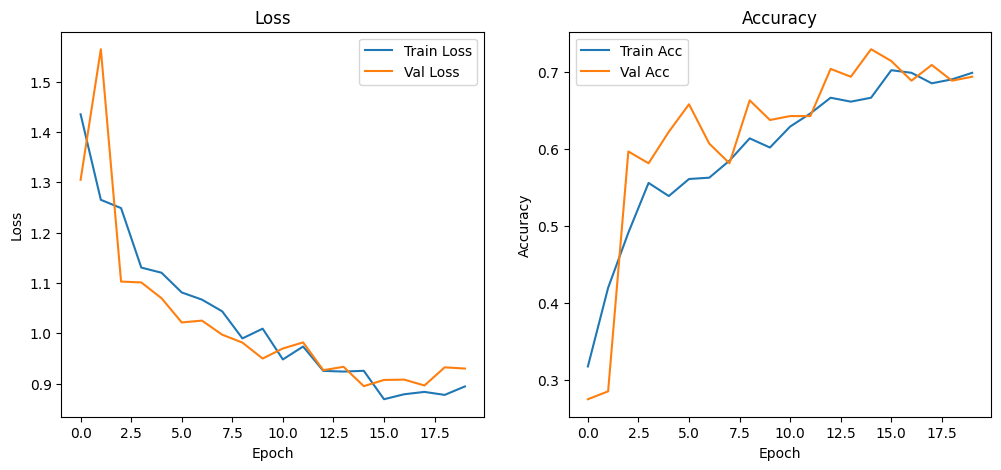

In [22]:
# ViT_B_32 MODEL
from image_loader import ImageDatasetLoader, your_transforms  # Assuming your_transforms is defined for your data

# Hyperparameters
batch_size = 32
epochs = 20
learning_rate = 5e-5
weight_decay = 1e-4
dropout_prob = 0.5
early_stop_patience = 5

# Transforms for ViT-B/32 (224x224 input size is standard)
vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT-B/32 also uses 224x224 by default
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = ImageDatasetLoader(csv_file=csv_file, img_dir=img_dir, transform=your_transforms)
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
labels = full_dataset.dataframe['mes_numeric'].values

# Load ViT-B/32 model
model = models.vit_b_32(weights=ViT_B_32_Weights.DEFAULT)
num_ftrs = model.heads.head.in_features
num_classes = len(full_dataset.label2idx)

# Replace classifier head
model.heads.head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Tracking variables
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Training loop
for epoch in range(epochs):
    if early_stop:
        print(f"🛑 Early stopping triggered at epoch {epoch + 1}")
        break

    model.train()
    running_loss, running_acc = 0.0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_acc += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_acc / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_images.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_acc += (val_preds == val_labels).sum().item()

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_acc / len(val_dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    scheduler.step()

    print(f"Epoch [{epoch + 1}/{epochs}] | Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    # Save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model_vit_b32.pth')
        print(f"✅ Saved best model at epoch {epoch + 1}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            early_stop = True
            print("⛔ Early stopping...")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()
plt.show()

Using device: cuda
Label2idx mapping in ImageDatasetLoader: {np.int64(1): 0, np.int64(0): 1, np.int64(2): 2, np.int64(3): 3}
Test dataset size: 197
Test Accuracy: 0.6650


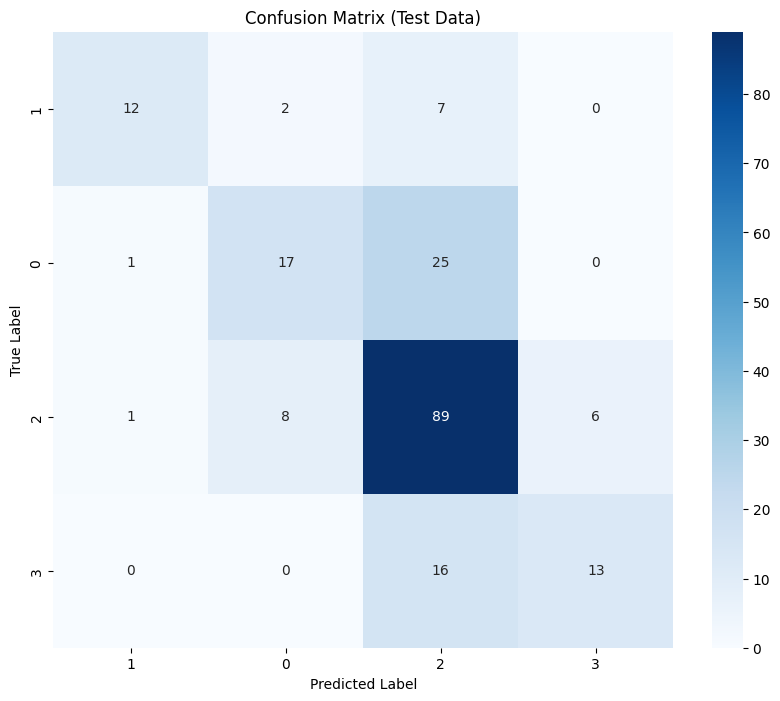


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.86      0.57      0.69        21
           0       0.63      0.40      0.49        43
           2       0.65      0.86      0.74       104
           3       0.68      0.45      0.54        29

    accuracy                           0.66       197
   macro avg       0.71      0.57      0.61       197
weighted avg       0.67      0.66      0.65       197



In [23]:
# ViT_B_32 MODEL CLASSIFICATION AND CONFUSION MATRIX

from image_loader import ImageDatasetLoader, your_transforms  # Assuming your_transforms is defined for your data


# Hyperparameters
batch_size = 32

# Transforms for ViT-B/32 (224x224 input size is standard)
vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT-B/32 also uses 224x224 by default
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = ImageDatasetLoader(csv_file=csv_file, img_dir=img_dir, transform=your_transforms)
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
labels = full_dataset.dataframe['mes_numeric'].values

# Train/Val/Test split (same as training for consistency)
train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42, shuffle=True)  # 60% train, 40% temp
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42, shuffle=True)  # 50% val, 50% test (20% total test)

test_dataset = Subset(full_dataset, test_idx)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Test dataset size: {len(test_dataset)}")

# Load the best ViT-B/32 model
model = models.vit_b_32(weights=None)
num_ftrs = model.heads.head.in_features
num_classes = len(full_dataset.label2idx)

# Replace classifier head (must match the training architecture)
model.heads.head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model.load_state_dict(torch.load('best_model_vit_b32.pth'))  # Load the saved best weights
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Track predictions and ground truth
predictions = []
ground_truth = []

# Testing loop
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())

# Calculate Test Accuracy
accuracy = np.mean(np.array(predictions) == np.array(ground_truth))
print(f"Test Accuracy: {accuracy:.4f}")

# --- Confusion Matrix and Classification Report ---

# Get class names
class_names = [str(key) for key in full_dataset.label2idx.keys()]

# Generate confusion matrix
cm = confusion_matrix(ground_truth, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Print classification report
print("\nClassification Report (Test Data):")
print(classification_report(ground_truth, predictions, target_names=class_names))

Using device: cuda
Label2idx mapping in ImageDatasetLoader: {np.int64(1): 0, np.int64(0): 1, np.int64(2): 2, np.int64(3): 3}
idx_to_class mapping: {0: np.int64(1), 1: np.int64(0), 2: np.int64(2), 3: np.int64(3)}


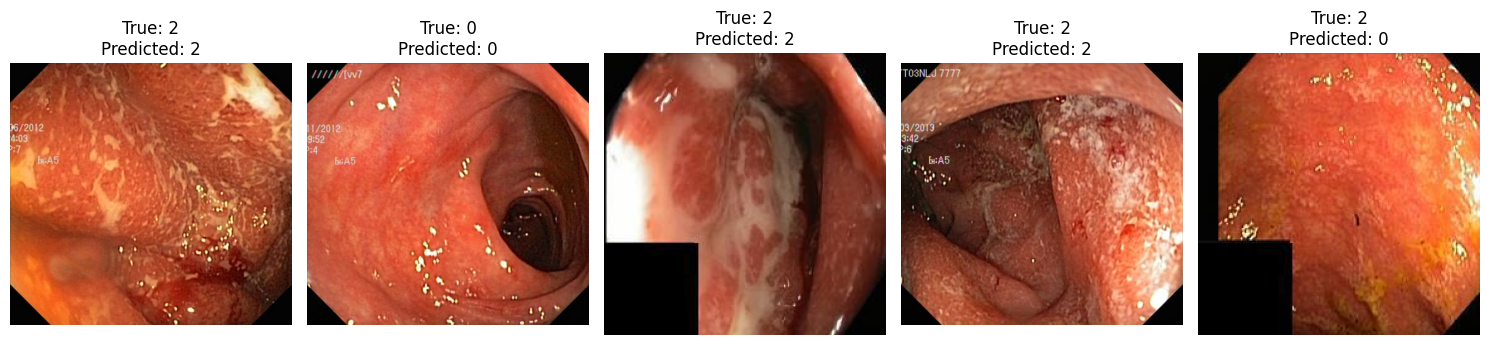

In [27]:
# Displaying the predicted output

from image_loader import ImageDatasetLoader, your_transforms  # Ensure your_transforms is defined
# Load the full dataset
full_dataset = ImageDatasetLoader(csv_file=csv_file, img_dir=img_dir, transform=your_transforms)

# Get the label to class name mapping
idx_to_class = {v: k for k, v in full_dataset.label2idx.items()}
print("idx_to_class mapping:", idx_to_class)

# Load the best ViT-B/32 model (ensure the path is correct)
model = models.vit_b_32(weights=None)
num_ftrs = model.heads.head.in_features
num_classes = len(full_dataset.label2idx)
model.heads.head = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, num_classes)
)
try:
    model.load_state_dict(torch.load('best_model_vit_b32.pth', map_location=device))
except FileNotFoundError:
    print("Error: 'best_model_vit_b32.pth' not found. Make sure the path is correct.")
    exit()
model.to(device)
model.eval()

# Define a transform for single image loading (without augmentation)
single_img_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming your ViT input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_single_image(img_path):
    try:
        image = Image.open(img_path).convert("RGB")
        image_tensor = single_img_transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted_idx = torch.max(outputs, 1)
        return idx_to_class.get(predicted_idx.item(), "Unknown")
    except Exception as e:
        print(f"Error predicting image {img_path}: {e}")
        return "Error"

# Get a few random image paths and true labels from the dataset
num_samples = 5
random_indices = random.sample(range(len(full_dataset)), num_samples)
sample_data = [(full_dataset.dataframe['img_url'].iloc[i].replace("image_folder/", "").replace("image_folder\\", ""),
                full_dataset.dataframe['mes_numeric'].iloc[i]) for i in random_indices]

# Display sample images and their predictions
plt.figure(figsize=(15, 8))
for i, (img_name, true_label_numeric) in enumerate(sample_data):
    img_path = os.path.join(img_dir, img_name)
    predicted_label = predict_single_image(img_path)
    true_label_str = idx_to_class.get(true_label_numeric, "Unknown")

    try:
        original_image = Image.open(img_path).convert("RGB")
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(original_image)
        plt.title(f"True: {true_label_str}\nPredicted: {predicted_label}")
        plt.axis('off')
    except FileNotFoundError:
        print(f"Error: Image not found at {img_path}")

plt.tight_layout()
plt.show()

In [7]:
# Loding the ResNet50 Saved Model

model = models.resnet50(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

state_dict = torch.load('best_model_resnet50_notebook2.pth')
model.load_state_dict(state_dict)
model.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Generating GRAD CAM Images

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# Grad-CAM storage
gradients = []
activations = []

# Define hooks
def save_gradients(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def save_activations(module, input, output):
    activations.append(output)

# Load your model (assuming conv layers are already loaded)
target_layer = model.layer4[-1].conv3
target_layer.register_forward_hook(save_activations)
target_layer.register_backward_hook(save_gradients)

# Grad-CAM function
def generate_gradcam(model, img_path):
    gradients.clear()
    activations.clear()
    
    image = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0)
    
    output = model(input_tensor)
    pred_class = output.argmax(dim=1)
    
    model.zero_grad()
    output[0, pred_class].backward()
    
    grad = gradients[0].detach()
    act = activations[0].detach()
    weights = grad.mean(dim=(2,3), keepdim=True)
    grad_cam = (weights * act).sum(dim=1).squeeze()
    grad_cam = torch.relu(grad_cam)
    
    grad_cam -= grad_cam.min()
    grad_cam /= grad_cam.max()
    grad_cam = grad_cam.numpy()
    
    heatmap = cv2.resize(grad_cam, (image.width, image.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_cv = np.array(image)[:, :, ::-1]
    superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)
    
    return superimposed_img

# Loop through images in your folder
image_folder = "/uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/image_folder"
output_folder = "./gradcam_results"
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(image_folder, filename)
        gradcam_img = generate_gradcam(model, img_path)
        
        save_path = os.path.join(output_folder, f"gradcam_{filename}")
        cv2.imwrite(save_path, gradcam_img)
        print(f"Saved Grad-CAM for {filename} at {save_path}")


/uolstore/home/users/qgqq3572/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Saved Grad-CAM for image_cli10cjc6141d0722d1qs92eh.jpg at ./gradcam_results/gradcam_image_cli10cjc6141d0722d1qs92eh.jpg
Saved Grad-CAM for Image_65517.png at ./gradcam_results/gradcam_Image_65517.png
Saved Grad-CAM for image_clhttfpy007n007400vdo7dsz.jpg at ./gradcam_results/gradcam_image_clhttfpy007n007400vdo7dsz.jpg
Saved Grad-CAM for Image_101919.png at ./gradcam_results/gradcam_Image_101919.png
Saved Grad-CAM for Image_104755.png at ./gradcam_results/gradcam_Image_104755.png
Saved Grad-CAM for Image_109595.png at ./gradcam_results/gradcam_Image_109595.png
Saved Grad-CAM for Image_127634.png at ./gradcam_results/gradcam_Image_127634.png
Saved Grad-CAM for Image_131990.png at ./gradcam_results/gradcam_Image_131990.png
Saved Grad-CAM for Image_134202.png at ./gradcam_results/gradcam_Image_134202.png
Saved Grad-CAM for Image_136447.png at ./gradcam_results/gradcam_Image_136447.png
Saved Grad-CAM for Image_140873.png at ./gradcam_results/gradcam_Image_140873.png
Saved Grad-CAM for Image

/tmp/ipykernel_31221/834279224.py:58: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


Saved Grad-CAM for image_clhpruvy401t007yu35zv35xj.jpg at ./gradcam_results/gradcam_image_clhpruvy401t007yu35zv35xj.jpg
Saved Grad-CAM for image_clhprwede00h107zkf3qa32r0.jpg at ./gradcam_results/gradcam_image_clhprwede00h107zkf3qa32r0.jpg
Saved Grad-CAM for image_clhprzg9o00fl07yabmwj0r4t.jpg at ./gradcam_results/gradcam_image_clhprzg9o00fl07yabmwj0r4t.jpg
Saved Grad-CAM for image_clhps192f024x07u74safabyi.jpg at ./gradcam_results/gradcam_image_clhps192f024x07u74safabyi.jpg
Saved Grad-CAM for image_clhps2m9003ab07x2gfb8087y.jpg at ./gradcam_results/gradcam_image_clhps2m9003ab07x2gfb8087y.jpg
Saved Grad-CAM for image_clhps4yw2004y07u9fqz04v2l.jpg at ./gradcam_results/gradcam_image_clhps4yw2004y07u9fqz04v2l.jpg
Saved Grad-CAM for image_clhps6bpf01it07wt9l9mgm0k.jpg at ./gradcam_results/gradcam_image_clhps6bpf01it07wt9l9mgm0k.jpg
Saved Grad-CAM for image_clhps7qsp00mi07y79jldhx3c (1).jpg at ./gradcam_results/gradcam_image_clhps7qsp00mi07y79jldhx3c (1).jpg
Saved Grad-CAM for image_clhps7q

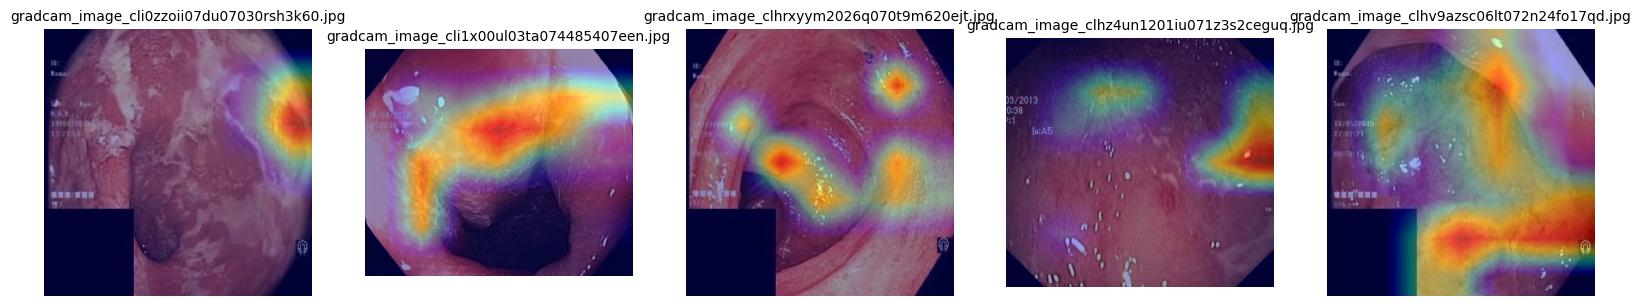

In [16]:
# DISPLAYING THE GRAD CAM IMAGES 

import random
gradcam_folder = "./gradcam_results"

# Get all image files
all_files = [f for f in os.listdir(gradcam_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Pick 5 images
sample_files = random.sample(all_files, 5)

# Display them
plt.figure(figsize=(20, 10))
for i, file in enumerate(sample_files):
    img_path = os.path.join(gradcam_folder, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(file, fontsize=10)
    plt.axis('off')

plt.show()


IMAGE CAPTIONING: PART 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from collections import Counter
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
from torchvision import models
from transformers import GPT2LMHeadModel
import matplotlib.pyplot as plt
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import defaultdict


In [7]:
# --- 1. Data Preparation ---
# Define paths
csv_file = r"/uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/uc-multimodal-main/dataframe_complete.csv"
img_dir = r"//uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

img_dir = r"//uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset"

Using device: cuda


In [38]:
# ---- DATASET ----
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, img_dir, transform=None, max_length=50):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.img_dir = img_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.loc[idx, "img_url"])
        caption = self.data.loc[idx, "caption"]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        encoding = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return image, encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0)



In [8]:
batch_size = 32
img_dir = r"//uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset"
train_dataset = ImageCaptionDataset(train_df, tokenizer, img_dir)
val_dataset = ImageCaptionDataset(val_df, tokenizer, img_dir)
test_dataset = ImageCaptionDataset(test_df, tokenizer, img_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# DATA LOADER
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Important!

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [41]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, path_to_trained_model):
        super().__init__()

        # Instantiate the base ResNet50 (pretrained=False)
        resnet = models.resnet50(pretrained=False)

        # Load the saved state dictionary
        checkpoint = torch.load(path_to_trained_model, map_location=device)

        # Filter out the classifier weights (fc layer)
        backbone_state_dict = {
            k: v for k, v in checkpoint.items() if not k.startswith('fc')
        }

        # Load weights into resnet
        resnet.load_state_dict(backbone_state_dict, strict=False)

        # Extract feature layers (drop final FC)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.backbone.to(device)  # ✅ move backbone to the right device

    def forward(self, x):
        with torch.no_grad():  # ✅ inference-safe
            features = self.backbone(x)  # (B, 2048, 1, 1)
            features = features.view(features.size(0), -1)  # (B, 2048)
        return features

# Usage example
resnet50_trained_model = 'best_model_resnet50_notebook2.pth'


In [10]:
# MODEL BUILDING

class ImageCaptioningModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        self.image_proj = nn.Linear(2048, self.gpt2.config.n_embd)
    
    def forward(self, image_features, captions, labels=None):
        projected = self.image_proj(image_features)  # (B, n_embd)
        projected = projected.unsqueeze(1)  # (B, 1, n_embd)

        # Get caption embeddings
        caption_embeddings = self.gpt2.transformer.wte(captions)  # (B, seq_len, n_embd)

        inputs_embeds = torch.cat((projected, caption_embeddings), dim=1)  # (B, 1+seq, n_embd)

        if labels is not None:
            # Adjust labels to match
            labels = torch.cat((
                torch.full((labels.size(0), 1), -100, device=labels.device),  # ignore image token
                labels
            ), dim=1)

        output = self.gpt2(inputs_embeds=inputs_embeds, labels=labels)
        return output


In [43]:
# TRAINING SCRIPT

model = ImageCaptioningModel().to(device)
feature_extractor = ResNetFeatureExtractor(resnet50_trained_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss, correct_train_tokens, total_train_tokens = 0, 0, 0

    # Training loop
    for images, input_ids, attention_mask in train_loader:
        images, input_ids, attention_mask = images.to(device), input_ids.to(device), attention_mask.to(device)
        
        with torch.no_grad():
            features = feature_extractor(images)

        labels = input_ids.clone()  # Ensure you're not modifying the original labels
        outputs = model(features, input_ids, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()http://localhost:8888/tree?token=439269e641ac64ba46dea21318916a53afd6b242c6202c58
        optimizer.step()

        total_train_loss += loss.item()

        # Calculate accuracy
        predicted_ids = torch.argmax(logits[:, 1:, :], dim=-1)  # (B, seq_len)
        true_ids = labels[:, 1:]  # Shift labels (exclude start token)

        # Mask padding tokens
        mask = (true_ids != tokenizer.pad_token_id)

        # Ensure predicted_ids and true_ids are of the same length for comparison
        min_len = min(predicted_ids.size(1), true_ids.size(1))
        predicted_ids = predicted_ids[:, :min_len]
        true_ids = true_ids[:, :min_len]
        mask = mask[:, :min_len]

        # Apply the mask to the comparison
        correct = (predicted_ids == true_ids) & mask
        correct_train_tokens += correct.sum().item()
        total_train_tokens += mask.sum().item()

    # Calculate average loss and accuracy for training
    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train_tokens / total_train_tokens if total_train_tokens > 0 else 0

    # Validation loop
    model.eval()
    total_val_loss, correct_val_tokens, total_val_tokens = 0, 0, 0
    with torch.no_grad():
        for images, input_ids, attention_mask in val_loader:
            images, input_ids, attention_mask = images.to(device), input_ids.to(device), attention_mask.to(device)
            features = feature_extractor(images)

            labels = input_ids
            outputs = model(features, input_ids, labels=labels)
            val_loss = outputs.loss
            logits = outputs.logits

            total_val_loss += val_loss.item()

            predicted_ids = torch.argmax(logits[:, 1:, :], dim=-1)  # (B, seq_len)
            true_ids = labels[:, 1:]  # Shift labels (exclude start token)

            # Mask padding tokens
            mask = (true_ids != tokenizer.pad_token_id)

            # Ensure predicted_ids and true_ids are of the same length for comparison
            min_len = min(predicted_ids.size(1), true_ids.size(1))
            predicted_ids = predicted_ids[:, :min_len]
            true_ids = true_ids[:, :min_len]
            mask = mask[:, :min_len]

            # Apply the mask to the comparison
            correct = (predicted_ids == true_ids) & mask
            correct_val_tokens += correct.sum().item()
            total_val_tokens += mask.sum().item()

    # Calculate average loss and accuracy for validation
    val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val_tokens / total_val_tokens if total_val_tokens > 0 else 0

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


torch.save(model.state_dict(), "image_caption_model.pth")
print("✅ Model saved successfully as image_caption_model.pth")



/uolstore/home/users/qgqq3572/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/uolstore/home/users/qgqq3572/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20 | Train Loss: 1.0925, Acc: 0.7822 | Val Loss: 0.0944, Acc: 0.9349
Epoch 2/20 | Train Loss: 0.1408, Acc: 0.9387 | Val Loss: 0.0885, Acc: 0.9534
Epoch 3/20 | Train Loss: 0.1187, Acc: 0.9463 | Val Loss: 0.0769, Acc: 0.9513
Epoch 4/20 | Train Loss: 0.0961, Acc: 0.9528 | Val Loss: 0.0698, Acc: 0.9528
Epoch 5/20 | Train Loss: 0.0909, Acc: 0.9547 | Val Loss: 0.0681, Acc: 0.9557
Epoch 6/20 | Train Loss: 0.0797, Acc: 0.9575 | Val Loss: 0.0652, Acc: 0.9611
Epoch 7/20 | Train Loss: 0.0701, Acc: 0.9589 | Val Loss: 0.0609, Acc: 0.9593
Epoch 8/20 | Train Loss: 0.0679, Acc: 0.9608 | Val Loss: 0.0593, Acc: 0.9614
Epoch 9/20 | Train Loss: 0.0611, Acc: 0.9641 | Val Loss: 0.0603, Acc: 0.9629
Epoch 10/20 | Train Loss: 0.0608, Acc: 0.9650 | Val Loss: 0.0597, Acc: 0.9620
Epoch 11/20 | Train Loss: 0.0546, Acc: 0.9667 | Val Loss: 0.0570, Acc: 0.9649
Epoch 12/20 | Train Loss: 0.0489, Acc: 0.9709 | Val Loss: 0.0572, Acc: 0.9649
Epoch 13/20 | Train Loss: 0.0530, Acc: 0.9685 | Val Loss: 0.0657, Acc: 0.

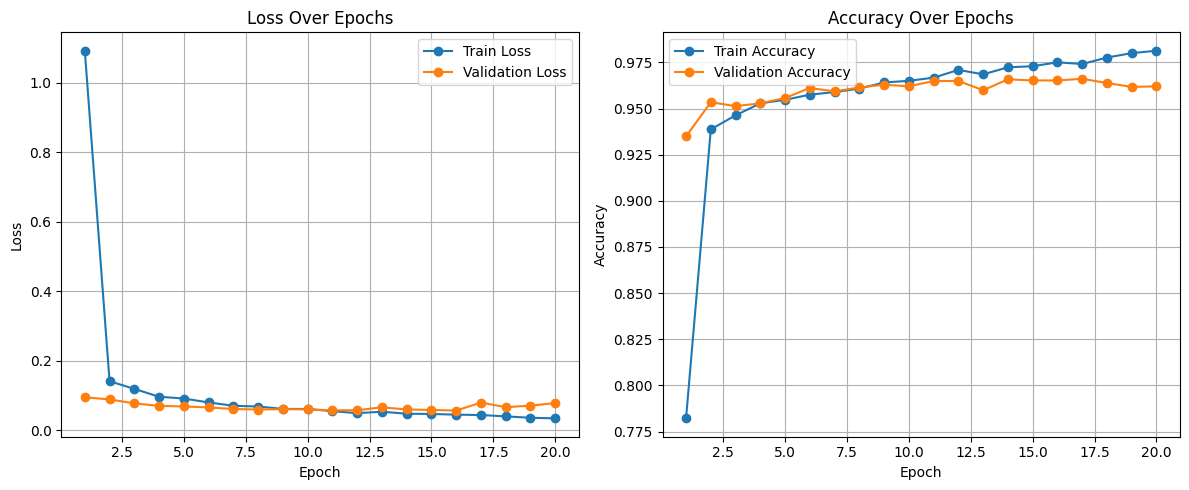

In [1]:
# Data from your 20 epochs
train_losses = [
    1.0925, 0.1408, 0.1187, 0.0961, 0.0909,
    0.0797, 0.0701, 0.0679, 0.0611, 0.0608,
    0.0546, 0.0489, 0.0530, 0.0471, 0.0465,
    0.0445, 0.0434, 0.0396, 0.0355, 0.0339
]

val_losses = [
    0.0944, 0.0885, 0.0769, 0.0698, 0.0681,
    0.0652, 0.0609, 0.0593, 0.0603, 0.0597,
    0.0570, 0.0572, 0.0657, 0.0594, 0.0581,
    0.0563, 0.0793, 0.0661, 0.0704, 0.0779
]

train_accuracies = [
    0.7822, 0.9387, 0.9463, 0.9528, 0.9547,
    0.9575, 0.9589, 0.9608, 0.9641, 0.9650,
    0.9667, 0.9709, 0.9685, 0.9723, 0.9729,
    0.9750, 0.9741, 0.9776, 0.9800, 0.9813
]

val_accuracies = [
    0.9349, 0.9534, 0.9513, 0.9528, 0.9557,
    0.9611, 0.9593, 0.9614, 0.9629, 0.9620,
    0.9649, 0.9649, 0.9599, 0.9658, 0.9652,
    0.9652, 0.9661, 0.9638, 0.9617, 0.9620
]

epochs = range(1, 21)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [26]:
model.eval()
total_test_loss, correct_test_tokens, total_test_tokens = 0, 0, 0
with torch.no_grad():
    for images, input_ids, attention_mask in test_loader:
        images, input_ids, attention_mask = images.to(device), input_ids.to(device), attention_mask.to(device)
        features = feature_extractor(images)

        labels = input_ids
        outputs = model(features, input_ids, labels=labels)
        test_loss = outputs.loss
        logits = outputs.logits

        total_test_loss += test_loss.item()

        predicted_ids = torch.argmax(logits[:, 1:, :], dim=-1)  # (B, seq_len)
        true_ids = labels[:, 1:]  # Shift labels (exclude start token)

        # Mask padding tokens
        mask = (true_ids != tokenizer.pad_token_id)

        # Ensure predicted_ids and true_ids are of the same length for comparison
        min_len = min(predicted_ids.size(1), true_ids.size(1))
        predicted_ids = predicted_ids[:, :min_len]
        true_ids = true_ids[:, :min_len]
        mask = mask[:, :min_len]

        # Apply the mask to the comparison
        correct = (predicted_ids == true_ids) & mask
        correct_test_tokens += correct.sum().item()
        total_test_tokens += mask.sum().item()

# Calculate average loss and accuracy for the test set
test_loss = total_test_loss / len(test_loader)
test_acc = correct_test_tokens / total_test_tokens if total_test_tokens > 0 else 0

print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

Test Loss: 0.0789, Accuracy: 0.9599


In [27]:
model.eval()
cosine_similarities = []

with torch.no_grad():
    for images, input_ids, attention_mask in test_loader:
        images, input_ids, attention_mask = images.to(device), input_ids.to(device), attention_mask.to(device)
        features = feature_extractor(images)  # (B, 2048)

        # Project image features to GPT2 embedding dim
        image_embeds = model.image_proj(features)  # (B, n_embd)

        # Get caption token embeddings from GPT2 (exclude special tokens if you want)
        caption_embeds = model.gpt2.transformer.wte(input_ids)  # (B, seq_len, n_embd)

        # For simplicity, average caption token embeddings to get sentence embedding
        caption_embeds_avg = caption_embeds.mean(dim=1)  # (B, n_embd)

        # Cosine similarity between projected image embedding and averaged caption embedding
        cos_sim = F.cosine_similarity(image_embeds, caption_embeds_avg, dim=1)  # (B,)

        cosine_similarities.extend(cos_sim.cpu().tolist())

# After loop, you can compute average cosine similarity
avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
print(f"Average cosine similarity on test set: {avg_cosine_similarity:.4f}")


Average cosine similarity on test set: 0.1278


In [44]:
def generate_caption(model, feature_extractor, image_path, tokenizer, max_length=50):
    model.eval()

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = feature_extractor(image)
        print("Feature vector (mean, std):", features.mean().item(), features.std().item())

        proj = model.image_proj(features).unsqueeze(1)  # (1, 1, n_embd)

        generated = proj
        generated_ids = []

        for _ in range(max_length):
            outputs = model.gpt2(inputs_embeds=generated)
            next_token_logits = outputs.logits[:, -1, :]
            next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1).to(device)  # shape (1,1)

            generated_ids.append(next_token_id.item())
            next_embed = model.gpt2.transformer.wte(next_token_id)
            generated = torch.cat((generated, next_embed), dim=1)

            if next_token_id.item() == tokenizer.eos_token_id:
                break

    caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return caption



'def generate_caption(model, feature_extractor, image_path, tokenizer, max_length=50):\n    model.eval()\n\n    image = Image.open(image_path).convert("RGB")\n    image = transform(image).unsqueeze(0).to(device)\n\n    with torch.no_grad():\n        features = feature_extractor(image)\n        print("Feature vector (mean, std):", features.mean().item(), features.std().item())\n\n        proj = model.image_proj(features).unsqueeze(1)  # (1, 1, n_embd)\n        bos_token_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else (tokenizer.cls_token_id if tokenizer.cls_token_id is not None else tokenizer.pad_token_id)\n        bos_embed = model.gpt2.transformer.wte(torch.tensor([[bos_token_id]]).to(device))\n        generated = torch.cat((proj, bos_embed), dim=1)  # image + [BOS]\n        generated_ids = []\n\n        for _ in range(max_length):\n            outputs = model.gpt2(inputs_embeds=generated)\n            next_token_logits = outputs.logits[:, -1, :]\n            ne

In [45]:
# Example image path
image_path = os.path.join(img_dir, "image_folder/image_clhozkhf506fj071ifv4f5rnc.jpg")

image_caption_model = ImageCaptioningModel().to(device)
image_caption_model.load_state_dict(torch.load("image_caption_model.pth", map_location=device))
image_caption_model.eval()

feature_extractor = ResNetFeatureExtractor(resnet50_trained_model).to(device)
feature_extractor.eval()

caption = generate_caption(
    model=image_caption_model,
    feature_extractor=feature_extractor,
    image_path=image_path,
    tokenizer=tokenizer
)

print("Generated Caption:", caption)


Feature vector (mean, std): 0.06807732582092285 0.2217228263616562
Generated Caption: there is complete obliteration of the vascular pattern the mucosa demonstrates marked erythema severe friability and deep ulcers luminal severe bleeding is present these findings support a mes3


'import matplotlib.pyplot as plt\n\n# --- Display the Image ---\ndef show_image_with_captions(image_path, generated_caption, original_caption):\n    image = Image.open(image_path).convert("RGB")\n\n    plt.figure(figsize=(6, 6))\n    plt.imshow(image)\n    plt.axis("off")\n    plt.title("Generated Caption:\n" + generated_caption, fontsize=10)\n    plt.figtext(0.5, -0.1, "Original Description:\n" + original_caption, wrap=True, horizontalalignment=\'center\', fontsize=10)\n    plt.tight_layout()\n    plt.show()\n\n# --- Get Original Description from CSV ---\nimport pandas as pd\n\nimage_path = "/uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/image_folder/image_clhhzvj9k0ayo07zrfwpiam9m.jpg"  # <-- PLACEHOLDER: replace with your image file path\n\ndf = pd.read_csv(csv_file)\nfilename = os.path.basename(image_path)\n\n# Get the row where img_url matches the filename\nmatch = df[df[\'img_url\'] == f"image_folder/{filename}"]\n\nif not match.empty:\n    ori

In [59]:
# CALCULATE BLEU SCORES

def calculate_bleu(image_path, reference_captions, model, feature_extractor, tokenizer):
   
    # Generate caption
    generated_caption = generate_caption(model, feature_extractor, image_path, tokenizer)

    # Tokenize
    reference_tokens = [ref.lower().split() for ref in reference_captions]
    candidate_tokens = generated_caption.lower().split()

    # Use smoothing to avoid BLEU=0 when n-grams are not present
    smoothing_fn = SmoothingFunction().method4

    # Calculate BLEU score (BLEU-4)
    bleu_score = sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothing_fn)

    return bleu_score, generated_caption


In [60]:
# USAGE OF THE CALCULATE BLEU SCORE FUNCTION

image_path = "/uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/image_folder/image_clhhzvj9k0ayo07zrfwpiam9m.jpg"
reference_captions = [
    "there is patchy obliteration of the vascular pattern the mucosa demonstrates no visible erythema no visible friability and no visible erosions no visible bleeding is present these findings support a mes1"
]

bleu, caption = calculate_bleu(image_path, reference_captions, model, feature_extractor, tokenizer)
print("Generated Caption:", caption)
print("BLEU Score:", bleu)


Feature vector (mean, std): 0.07921463251113892 0.20147931575775146
Generated Caption: there is patchy obliteration of the vascular pattern the mucosa demonstrates moderate erythema low friability and erosions no visible bleeding is present these findings support a mes1
BLEU Score: 0.667461060141043


In [49]:
# Base folder where images are stored
base_image_path = "/uolstore/home/userCAPTIONINGs/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset"

# Load CSV
df = pd.read_csv(csv_file)

# Create dictionary: full image path -> list of captions
image_caption_dict = defaultdict(list)

for _, row in df.iterrows():
    image_filename = row['img_url']  # e.g. "image_clhhyjzdx00os07xbernefuly.jpg"
    caption = row['description']
    
    # Join base path with image filename to get full path
    full_image_path = os.path.join(base_image_path, image_filename)
    
    image_caption_dict[full_image_path].append(caption)


In [48]:
import nltk
nltk.download('punkt')
import nltk
print(nltk.data.find('tokenizers/punkt/english.pickle'))


/uolstore/home/users/qgqq3572/nltk_data/tokenizers/punkt/english.pickle


[nltk_data] Downloading package punkt to
[nltk_data]     /uolstore/home/users/qgqq3572/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(image_path, reference_captions, model, feature_extractor, tokenizer):
    # Generate caption
    generated_caption = generate_caption(model, feature_extractor, image_path, tokenizer)
    
    # Tokenize references and candidate
    reference_tokens = [ref.lower().split() for ref in reference_captions]
    candidate_tokens = generated_caption.lower().split()
    
    # Use smoothing function to handle zero counts
    smoothing_fn = SmoothingFunction().method4
    
    # Calculate BLEU-4 score
    bleu_score = sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothing_fn)
    
    return bleu_score, generated_caption

all_bleu_scores = []
all_results = []

for image_path, captions in image_caption_dict.items():
    try:
        bleu, gen_caption = calculate_bleu(image_path, captions, model, feature_extractor, tokenizer)
        all_bleu_scores.append(bleu)
        all_results.append((image_path, gen_caption, bleu))
        print(f"Image: {image_path}\nGenerated Caption: {gen_caption}\nBLEU Score: {bleu:.4f}\n")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

if all_bleu_scores:
    avg_bleu = sum(all_bleu_scores) / len(all_bleu_scores)
else:
    avg_bleu = 0.0

print(f"Average BLEU score over all images: {avg_bleu:.4f}")


Feature vector (mean, std): 0.061885494738817215 0.09196004271507263
Image: /uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/image_folder/image_clhhyjzdx00os07xbernefuly.jpg
Generated Caption: there is complete obliteration of the vascular pattern the mucosa demonstrates moderate erythema low friability and no visible erosions no visible bleeding is present these findings support a mes2
BLEU Score: 0.8798

Feature vector (mean, std): 0.06335189193487167 0.08150385320186615
Image: /uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/image_folder/image_clhhyjzoj03mw07tl9vpdgbec.jpg
Generated Caption: there is complete obliteration of the vascular pattern the mucosa demonstrates moderate erythema low friability and no visible erosions no visible bleeding is present these findings support a mes2
BLEU Score: 0.9636

Feature vector (mean, std): 0.05811116844415665 0.09332120418548584
Image: /uolstore/home/users/qgqq3572/Download

In [52]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import defaultdict

def calculate_bleu_scores(image_path, reference_captions, model, feature_extractor, tokenizer):
    """
    Calculates BLEU-1 to BLEU-4 scores for a single image caption against multiple references.

    Args:
        image_path (str): Path to the image.
        reference_captions (List[str]): List of reference captions for the image.
        model: Trained captioning model.
        feature_extractor: Image feature extractor.
        tokenizer: Tokenizer used for decoding tokens.

    Returns:
        dict: Dictionary with BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores.
        str: Generated caption.
    """
    generated_caption = generate_caption(model, feature_extractor, image_path, tokenizer)

    reference_tokens = [ref.lower().split() for ref in reference_captions]
    candidate_tokens = generated_caption.lower().split()

    smoothing_fn = SmoothingFunction().method4

    bleu_scores = {}
    for i in range(1, 5):
        weights = tuple((1.0 / i for _ in range(i))) + tuple(0.0 for _ in range(4 - i))
        bleu = sentence_bleu(reference_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing_fn)
        bleu_scores[f'bleu_{i}'] = bleu

    return bleu_scores, generated_caption


all_results = []

for image_path, captions in image_caption_dict.items():
    try:
        bleu_scores, gen_caption = calculate_bleu_scores(image_path, captions, model, feature_extractor, tokenizer)
        row = {
            "image_path": image_path,
            "generated_caption": gen_caption,
            **bleu_scores
        }
        all_results.append(row)
        print(f"Image: {image_path}")
        print(f"Generated Caption: {gen_caption}")
        print(f"BLEU-1: {bleu_scores['bleu_1']:.4f}, BLEU-2: {bleu_scores['bleu_2']:.4f}, BLEU-3: {bleu_scores['bleu_3']:.4f}, BLEU-4: {bleu_scores['bleu_4']:.4f}\n")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Calculate average scores
avg_scores = results_df[['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']].mean()

print("Average BLEU Scores:")
print(avg_scores)

# Save to CSV
results_df.to_csv("captioning_results.csv", index=False)


Feature vector (mean, std): 0.0613366961479187 0.16540303826332092
Image: /uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/image_folder/image_clhhyjzdx00os07xbernefuly.jpg
Generated Caption: there is complete obliteration of the vascular pattern the mucosa demonstrates marked erythema moderate friability and superficial ulcers mucosal bleeding is present these findings support a mes2
BLEU-1: 0.7222, BLEU-2: 0.6220, BLEU-3: 0.5407, BLEU-4: 0.4844

Feature vector (mean, std): 0.04046405851840973 0.17090603709220886
Image: /uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset/image_folder/image_clhhyjzoj03mw07tl9vpdgbec.jpg
Generated Caption: there is complete obliteration of the vascular pattern the mucosa demonstrates moderate erythema low friability and no visible erosions no visible bleeding is present these findings support a mes2
BLEU-1: 0.9655, BLEU-2: 0.9649, BLEU-3: 0.9643, BLEU-4: 0.9636

Feature vector (mean, std): 

Enhanced Model Architecture: PART 3

In [ ]:
import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [52]:
# Dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, img_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.img_dir = img_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.loc[idx, "img_url"])
        caption = self.data.loc[idx, "caption"]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        encoding = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=50,
            return_tensors="pt"
        )

        return image, encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0)


# Patchify function (batch input)
def patchify(images, patch_size=16):
    B, C, H, W = images.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch_size"

    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(B, C, -1, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4)  # (B, N, C, patch_size, patch_size)
    return patches


def mask_and_shuffle_patches(patches, mask_ratio=0.3):
    B, N, C, H, W = patches.shape
    num_mask = int(mask_ratio * N)

    all_indices = list(range(N))
    mask_indices = random.sample(all_indices, num_mask)
    visible_indices = [i for i in all_indices if i not in mask_indices]
    random.shuffle(visible_indices)

    masked_patches = patches.clone()
    masked_patches[:, mask_indices] = 0

    reordered_patches = torch.cat([masked_patches[:, visible_indices], masked_patches[:, mask_indices]], dim=1)
    return reordered_patches, mask_indices, visible_indices


# PatchEncoder
class PatchEncoder(nn.Module):
    def __init__(self, patch_size=16, embed_dim=768, in_channels=3):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_proj = nn.Linear(in_channels * patch_size * patch_size, embed_dim)
        

    def forward(self, patches):
        batch_size, num_patches, channels, patch_h, patch_w = patches.shape
        patches_flat = patches.reshape(batch_size, num_patches, -1)
        embeddings = self.patch_proj(patches_flat)  # shape: (batch_size, num_patches, embed_dim)
        return embeddings

def calculate_accuracy(predictions, labels, pad_token_id):
    # predictions: logits from model (B, seq_len, vocab_size)
    # labels: (B, seq_len)
    pred_tokens = predictions.argmax(dim=-1)  # (B, seq_len)
    
    # Create mask to ignore pad tokens
    mask = labels != pad_token_id
    
    correct = (pred_tokens == labels) & mask
    accuracy = correct.sum().float() / mask.sum().float()
    return accuracy.item()


# Training loop
def train_epoch(model, patch_encoder, dataloader, tokenizer, device, optimizer, mask_ratio=0.3, max_len=50, epoch=0, total_epochs=20):
    model.train()
    patch_encoder.train()
    total_loss = 0
    total_acc = 0
    count = 0

    pad_token_id = tokenizer.pad_token_id

    for images, captions, attn_masks in dataloader:
        images = images.to(device)
        captions = captions.to(device)
        attn_masks = attn_masks.to(device)

        optimizer.zero_grad()

        patches = patchify(images, patch_size=patch_encoder.patch_size)
        corrupted_patches, _, _ = mask_and_shuffle_patches(patches, mask_ratio=mask_ratio)
        corrupted_patches = corrupted_patches.to(device)

        encoded_patches = patch_encoder(corrupted_patches)

        seq_len = encoded_patches.shape[1]
        if seq_len > max_len:
            encoded_patches = encoded_patches[:, :max_len, :]
        elif seq_len < max_len:
            pad_length = max_len - seq_len
            pad_tensor = torch.zeros(encoded_patches.size(0), pad_length, encoded_patches.size(2), device=device)
            encoded_patches = torch.cat([encoded_patches, pad_tensor], dim=1)

        outputs = model.gpt2(inputs_embeds=encoded_patches, labels=captions)
        loss = outputs.loss
        logits = outputs.logits  # (B, seq_len, vocab_size)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        acc = calculate_accuracy(logits, captions, pad_token_id)
        total_acc += acc
        count += 1

    avg_loss = total_loss / count
    avg_acc = total_acc / count
    print(f"Epoch {epoch + 1}/{total_epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")
    return avg_loss, avg_acc


def validate_epoch(model, patch_encoder, val_loader, tokenizer, device, mask_ratio=0.3, max_len=50):
    model.eval()
    patch_encoder.eval()
    total_loss = 0
    total_acc = 0
    count = 0

    pad_token_id = tokenizer.pad_token_id

    with torch.no_grad():
        for images, captions, attn_masks in val_loader:
            images = images.to(device)
            captions = captions.to(device)
            attn_masks = attn_masks.to(device)

            patches = patchify(images, patch_size=patch_encoder.patch_size)
            corrupted_patches, _, _ = mask_and_shuffle_patches(patches, mask_ratio=mask_ratio)
            corrupted_patches = corrupted_patches.to(device)

            encoded_patches = patch_encoder(corrupted_patches)

            seq_len = encoded_patches.shape[1]
            if seq_len > max_len:
                encoded_patches = encoded_patches[:, :max_len, :]
            elif seq_len < max_len:
                pad_length = max_len - seq_len
                pad_tensor = torch.zeros(encoded_patches.size(0), pad_length, encoded_patches.size(2), device=device)
                encoded_patches = torch.cat([encoded_patches, pad_tensor], dim=1)

            outputs = model.gpt2(inputs_embeds=encoded_patches, labels=captions)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            acc = calculate_accuracy(logits, captions, pad_token_id)
            total_acc += acc
            count += 1

    avg_loss = total_loss / count
    avg_acc = total_acc / count
    print(f"Validation Loss: {avg_loss:.4f} | Validation Acc: {avg_acc:.4f}")
    return avg_loss, avg_acc




# ======== Setup ========

img_dir = r"/uolstore/home/users/qgqq3572/Downloads/McsProject 1/Project/UC_multiModal_dataset"

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

train_dataset = ImageCaptionDataset(train_df, tokenizer, img_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

encoder = PatchEncoder(patch_size=16, embed_dim=768).to(device)

model = ImageCaptioningModel(tokenizer).to(device)  # Your model with a `gpt2` attribute

optimizer = torch.optim.Adam(list(model.parameters()) + list(encoder.parameters()), lr=1e-4)

num_epochs = 20


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, encoder, train_loader, tokenizer, device, optimizer, epoch=epoch, total_epochs=num_epochs)
    val_loss, val_acc = validate_epoch(model, encoder, val_loader, tokenizer, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)



Epoch 1/20
Epoch 1/20 | Train Loss: 4.9366 | Train Acc: 0.0104
Validation Loss: 3.3144 | Validation Acc: 0.0000
Epoch 2/20
Epoch 2/20 | Train Loss: 3.4183 | Train Acc: 0.0109
Validation Loss: 2.9549 | Validation Acc: 0.0192
Epoch 3/20
Epoch 3/20 | Train Loss: 2.8863 | Train Acc: 0.0349
Validation Loss: 2.4774 | Validation Acc: 0.0244
Epoch 4/20
Epoch 4/20 | Train Loss: 2.5089 | Train Acc: 0.0599
Validation Loss: 2.3385 | Validation Acc: 0.0763
Epoch 5/20
Epoch 5/20 | Train Loss: 2.2635 | Train Acc: 0.0837
Validation Loss: 1.9425 | Validation Acc: 0.0798
Epoch 6/20
Epoch 6/20 | Train Loss: 2.1665 | Train Acc: 0.0955
Validation Loss: 2.2734 | Validation Acc: 0.1176
Epoch 7/20
Epoch 7/20 | Train Loss: 2.0772 | Train Acc: 0.1080
Validation Loss: 1.7856 | Validation Acc: 0.0960
Epoch 8/20
Epoch 8/20 | Train Loss: 1.9550 | Train Acc: 0.1175
Validation Loss: 1.6616 | Validation Acc: 0.1090
Epoch 9/20
Epoch 9/20 | Train Loss: 1.9137 | Train Acc: 0.1275
Validation Loss: 1.7862 | Validation Acc:

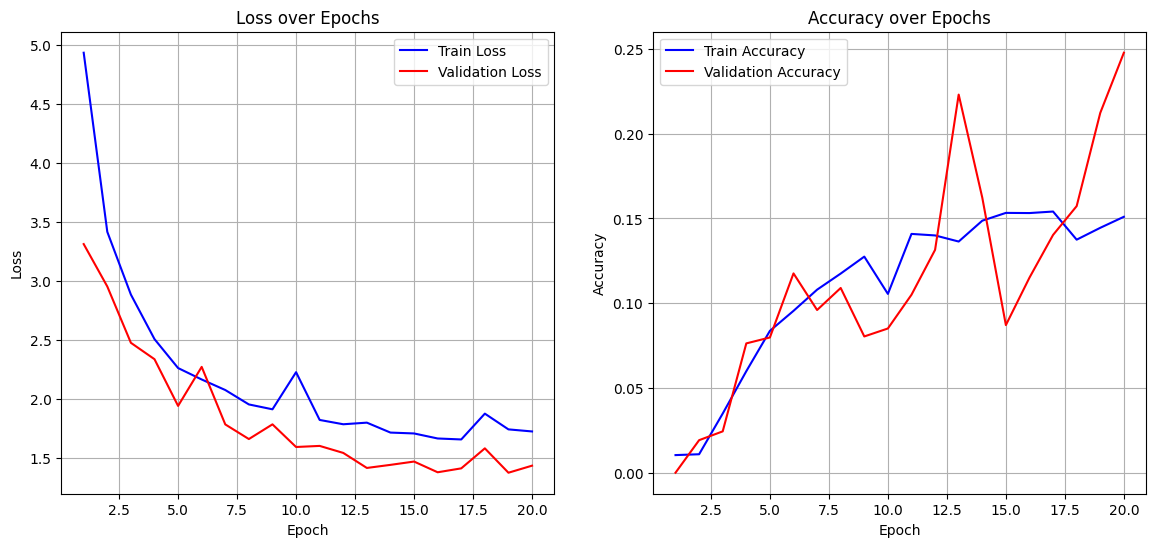

In [53]:
# Epochs
epochs = list(range(1, 21))

# Training losses per epoch
train_losses = [
    4.9366, 3.4183, 2.8863, 2.5089, 2.2635, 2.1665, 2.0772, 1.9550, 1.9137, 2.2284,
    1.8235, 1.7869, 1.8006, 1.7164, 1.7090, 1.6664, 1.6581, 1.8770, 1.7435, 1.7260
]

# Training accuracies per epoch
train_acc = [
    0.0104, 0.0109, 0.0349, 0.0599, 0.0837, 0.0955, 0.1080, 0.1175, 0.1275, 0.1055,
    0.1409, 0.1400, 0.1364, 0.1487, 0.1533, 0.1532, 0.1541, 0.1375, 0.1445, 0.1510
]

# Validation losses per epoch
val_losses = [
    3.3144, 2.9549, 2.4774, 2.3385, 1.9425, 2.2734, 1.7856, 1.6616, 1.7862, 1.5942,
    1.6034, 1.5440, 1.4166, 1.4427, 1.4708, 1.3799, 1.4131, 1.5827, 1.3761, 1.4359
]

# Validation accuracies per epoch
val_acc = [
    0.0000, 0.0192, 0.0244, 0.0763, 0.0798, 0.1176, 0.0960, 0.1090, 0.0804, 0.0851,
    0.1050, 0.1315, 0.2231, 0.1623, 0.0871, 0.1151, 0.1403, 0.1573, 0.2123, 0.2478
]Epoch 1/20 | Train Loss: 1.0925, Acc: 0.7822 | Val Loss: 0.0944, Acc: 0.9349
Epoch 2/20 | Train Loss: 0.1408, Acc: 0.9387 | Val Loss: 0.0885, Acc: 0.9534
Epoch 3/20 | Train Loss: 0.1187, Acc: 0.9463 | Val Loss: 0.0769, Acc: 0.9513
Epoch 4/20 | Train Loss: 0.0961, Acc: 0.9528 | Val Loss: 0.0698, Acc: 0.9528
Epoch 5/20 | Train Loss: 0.0909, Acc: 0.9547 | Val Loss: 0.0681, Acc: 0.9557
Epoch 6/20 | Train Loss: 0.0797, Acc: 0.9575 | Val Loss: 0.0652, Acc: 0.9611
Epoch 7/20 | Train Loss: 0.0701, Acc: 0.9589 | Val Loss: 0.0609, Acc: 0.9593
Epoch 8/20 | Train Loss: 0.0679, Acc: 0.9608 | Val Loss: 0.0593, Acc: 0.9614
Epoch 9/20 | Train Loss: 0.0611, Acc: 0.9641 | Val Loss: 0.0603, Acc: 0.9629
Epoch 10/20 | Train Loss: 0.0608, Acc: 0.9650 | Val Loss: 0.0597, Acc: 0.9620
Epoch 11/20 | Train Loss: 0.0546, Acc: 0.9667 | Val Loss: 0.0570, Acc: 0.9649
Epoch 12/20 | Train Loss: 0.0489, Acc: 0.9709 | Val Loss: 0.0572, Acc: 0.9649
Epoch 13/20 | Train Loss: 0.0530, Acc: 0.9685 | Val Loss: 0.0657, Acc: 0.9599
Epoch 14/20 | Train Loss: 0.0471, Acc: 0.9723 | Val Loss: 0.0594, Acc: 0.9658
Epoch 15/20 | Train Loss: 0.0465, Acc: 0.9729 | Val Loss: 0.0581, Acc: 0.9652
Epoch 16/20 | Train Loss: 0.0445, Acc: 0.9750 | Val Loss: 0.0563, Acc: 0.9652
Epoch 17/20 | Train Loss: 0.0434, Acc: 0.9741 | Val Loss: 0.0793, Acc: 0.9661
Epoch 18/20 | Train Loss: 0.0396, Acc: 0.9776 | Val Loss: 0.0661, Acc: 0.9638
Epoch 19/20 | Train Loss: 0.0355, Acc: 0.9800 | Val Loss: 0.0704, Acc: 0.9617
Epoch 20/20 | Train Loss: 0.0339, Acc: 0.9813 | Val Loss: 0.0779, Acc: 0.9620

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.show()


In [40]:
prompt = "a photo of"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
generated_ids = model.gpt2.generate(
    input_ids=input_ids,
    max_length=30,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    do_sample=True,
    temperature=1.0,
    top_k=50,
)
caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Caption from text prompt:", caption)


Caption from text prompt: a photo of complete obliterosa of vascular vascular the theosaosa demonstrates visible erythemama


In [65]:
model.eval()
encoder.eval()
cosine_similarities = []

with torch.no_grad():
    for images, input_ids, attention_mask in test_loader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Step 1: Process images
        patches = patchify(images, patch_size=encoder.patch_size)
        corrupted_patches, _, _ = mask_and_shuffle_patches(patches, mask_ratio=0.3)
        corrupted_patches = corrupted_patches.to(device)

        encoded_patches = encoder(corrupted_patches)  # (B, num_patches, embed_dim)

        # Average patch embeddings → acts as image embedding
        image_embeds = encoded_patches.mean(dim=1)  # (B, embed_dim)

        # Step 2: Get caption embeddings from GPT-2
        caption_embeds = model.gpt2.transformer.wte(input_ids)  # (B, seq_len, embed_dim)

        # Average caption token embeddings
        caption_embeds_avg = caption_embeds.mean(dim=1)  # (B, embed_dim)

        # Step 3: Cosine similarity
        cos_sim = F.cosine_similarity(image_embeds, caption_embeds_avg, dim=1)  # (B,)
        cosine_similarities.extend(cos_sim.cpu().tolist())
If you want, I can also give you the PyTorch version for Grad-CAM so you can choose based on your training framework.
Do you want me to make the PyTorch medical Grad-CAM version next?
# Final average
avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
print(f"Average cosine similarity on test set: {avg_cosine_similarity:.4f}")


Average cosine similarity on test set: 0.1845
